In [39]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [40]:
# Read the file 
gdf=gpd.read_file("s3://veda-data-store-staging/EIS/other/feds-output-conus/latest/perim-large.fgb", engine="pyogrio")

In [41]:
# Change thr crs if needed
gdf=gdf.to_crs(4326)

In [42]:
# Choose any row form the geo dataframe
gdf=gdf.query("fid==34789")

# Find the centroid of each Polygon
gdf["centroid"] = gdf["geometry"].to_crs(crs=gdf.crs).centroid

# Draw a buffer around the perimeter of the polygon to extend it
gdf["buf"]=gdf["geometry"].buffer(0.005)

<AxesSubplot:>

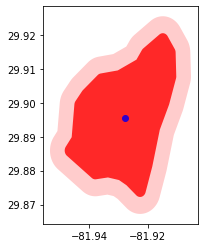

In [43]:
# Plotting the buffered polygon with centroid
ax= gdf.plot(alpha=0.8,color='red')
gdf['centroid'].plot(ax=ax, color="blue")
gdf['buf'].plot(ax=ax,color='red', alpha=0.2)

In [44]:
# Read the fire data
ds= xr.open_zarr("s3://veda-data-store-staging/EIS/zarr/FWI.GEOS-5.zarr")

In [45]:
# Renaming the axis
ds=ds.rename({"lat": 'y', "lon": 'x'})

# Changing crs to match with the geo dataframe
ds.rio.write_crs("epsg:4326", inplace=True)

# Taking the variable of interest
ds=ds["GEOS-5_FWI"]

In [46]:
# Selecting data on time range.
ds=ds.sel(time=slice("2021-07-01","2021-07-12"))

In [47]:
# Clipping the fire data over the specified region
clipped = ds.rio.clip(gdf.buf, gdf.crs, drop=True,all_touched=True)

In [48]:
# Taking mean over the region
x= clipped.mean(dim=['x','y'],skipna=True)

In [57]:
# Diagonally shiftting the data for chiclet plot
tmp = np.array([np.roll(np.array(x.sel(forecast=i).values), i) for i in range(9)])
for i in range(len(tmp)):
    tmp[i,:i]=np.NaN
ys = np.arange(9)
xs = xs = x.time.values
zs=tmp

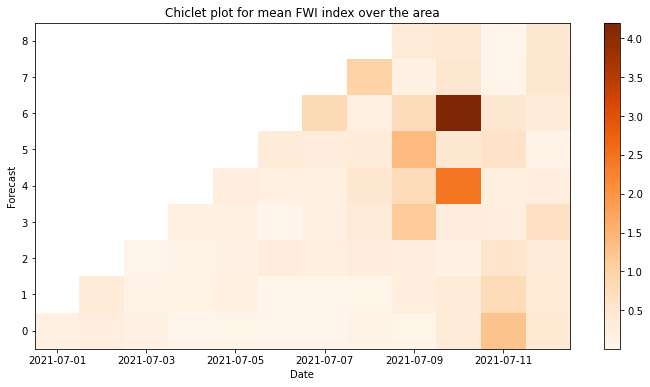

In [66]:
# Display the Plot
plt.figure(figsize=(12,6))
plt.title("Chiclet plot for mean FWI index over the area")
plt.pcolormesh(xs,ys,tmp, cmap="Oranges")
plt.xlabel("Date")
plt.ylabel("Forecast")
plt.colorbar()
plt.show()